In [3]:
# we are using pretained glove word embeddings for this project
# word embedding is used to capture word's meaning in some fixed length numbers   

In [ ]:
# importing libraries
from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import string 
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#defining some global variables

batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
fname="500_Reddit_users_posts_labels.csv"

In [0]:
fname1="train_dataset.xlsx"

In [0]:
#reading data from training dataset
data1=pd.read_excel(fname1)

In [0]:
#first 10 items of the dataset
data1.head(10)

Tweets Suicidal
0        Taylor Swift's new album is making me happy      non
1               Zac Efron is unbelievably attractive      non
2                                i miss my childhood      non
3  If you like golf and aren't watching these las...      non
4  Happy Father's Day to the best Husband anyone ...      non
5  Evidently if you say no foam for a latte at @S...      non
6                                Happy Memorial Day!      non
7                                          Good game      non
8  Stop the discrimination, there is a difference...      non
9  The first couple videos are preproduction then...      non

In [0]:
# defining onehotencoder will be used for label encoding
encoder = OneHotEncoder(sparse=False)

In [0]:
# separating only sentences
sui_data_X=data1["Tweets"].values

In [0]:
# getting only labels
labels = data1["Suicidal"].values

In [0]:
len(sui_data_X),len(labels)

(260, 260)

In [0]:
# all punctuations will be removed
puncs=string.punctuation

In [0]:
# sentence cleaning procedure

def clean_sentence(sentence):
  # lowering each words
  sentence = sentence.lower()
  # removing all characters except alphanumericals and \' character
  sentence = re.sub( "[^a-zA-Z0-9\']", ' ', sentence )
  # sentence=re.sub("\s+" , " ", sentence)
  # splitting sentences into words
  words = sentence.split()
  # removing all punctuations
  new_words=[ w for w in words if w not in puncs  ]
  # joining words to create clean final sentence
  sen=" ".join(new_words)
  return sen.strip()

In [0]:
# cleaning all sentences and labels
update_sentences=[]
update_labels=[]
for s,label in zip(sui_data_X,labels):
  s=clean_sentence(s)
  update_labels.append(label)
  update_sentences.append(s)

In [0]:
# converting list to numpy arrays
update_sentences=np.array(update_sentences)
update_labels=np.array(update_labels)

In [0]:
# reshaping 1d label array to 2d array
labels=update_labels.reshape((-1, 1))

#enoding label to onehot
labels=encoder.fit_transform(labels)

In [0]:
# splitting sentence and label to train, test data
sentences_train, sentences_test, y_train, y_test = train_test_split(update_sentences, labels, test_size=0.10, random_state=1000)

In [0]:
# okenizer to encode words to numbers
tokenizer = Tokenizer(num_words=20000, oov_token='<unw>')

In [0]:
# fitting tokenizer on train sentences only
tokenizer.fit_on_texts(sentences_train)

In [0]:
# converting words on train and test set to numbers
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [0]:
# maxlength of the sentences to trim
maxlen = 200

In [0]:
# pad small sentences to maxlength
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [0]:
max_features=20000

In [0]:
word_index = tokenizer.word_index

In [0]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

789


In [0]:
# embedding vector dimension
embedding_dim=100

In [0]:
# creating word wise embedding vectorized dictionary
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# first create a matrix of zeros, this is embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer,  try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #  found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)
f.close()

In [0]:
# importing libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.models import Sequential
from keras import layers

In [0]:
# creating our model
model = Sequential()
model.add(Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=maxlen,
                    trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32)))
model.add(Dropout(0.25))
model.add(Dense(units=2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          78900     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          84992     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41472     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       

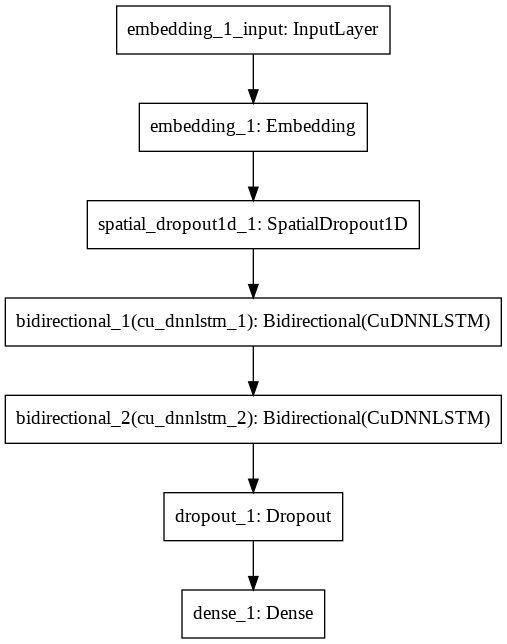

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [0]:
# training the model for 50 times
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

# plot_history(history)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 234 samples, validate on 26 samples
Epoch 1/50





234/234 [==============================] - 15s 65ms/step - loss: 0.5988 - acc: 0.7393 - val_loss: 0.6462 - val_acc: 0.6538
Epoch 2/50
234/234 [==============================] - 1s 4ms/step - loss: 0.5549 - acc: 0.7521 - val_loss: 0.7078 - val_acc: 0.6538
Epoch 3/50
234/234 [==============================] - 1s 4ms/step - loss: 0.5770 - acc: 0.7479 - val_loss: 0.6178 - val_acc: 0.6538
Epoch 4/50
234/234 [==============================] - 1s 4ms/step - loss: 0.5222 - acc: 0.7521 - val_loss: 0.6128 - val_acc: 0.6538
Epoch 5/50
234/234 [==============================] - 1s 4ms/step - loss: 0.4841 - acc: 0.7735 - val_loss: 0.5768 - val_acc: 0.6538
Epoch 6/50
234/234 [==============================] - 1s 4ms/step - loss: 0.4173 - acc: 0.7863 - val_loss: 0.6092 - val_acc: 0.6538
Epoch 7/50
234/234 [==============================] - 1s 4m

In [0]:
# evaluating model's performance 
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9957
Testing Accuracy:  0.5000


In [0]:
# saving trained model for future usage
model.save("suicide_classifier.h5")

In [0]:
sui_data=list(data1[data1["Suicidal"]=="oui"]["Tweets"])
non_sui_data=list(data1[data1["Suicidal"]=="non"]["Tweets"])

In [0]:
sui_data[:5]

['If one day I die, I think everyone would be happy.',
 'I wish I was gone long ago',
 'want death',
 "I'm so fucked up and I'm honestly struggling so hard",
 'I would kill myself, but the thought of never seeing you again hurts too much']

In [0]:
train = tokenizer.texts_to_sequences(sui_data[:5])

In [0]:
train

[[29, 28, 55, 2, 73, 2, 147, 114, 51, 19, 42],
 [2, 82, 2, 56, 291, 648, 649],
 [15, 226],
 [7, 10, 629, 44, 11, 7, 233, 630, 10, 125],
 [2, 51, 75, 27, 24, 4, 158, 12, 63, 416, 8, 161, 224, 138, 37]]

In [0]:
tokenizer.index_word[27]

'myself'